In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install ann_visualizer
!pip install graphviz

In [130]:
import numpy as np
import os
import pickle
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
# from ann_visualizer.visualize import ann_viz
from sklearn.metrics import confusion_matrix

In [131]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [132]:
def largest_prime_factor(n):
    i = 2
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
    return n

In [ ]:
# dataset_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset.p')
# available_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/dataset-available-Tr.p')

# Generar conjuntos de entrenamiento, validación y prueba (con dummies)

Total de entradas: 1610 $\rightarrow$ 1614 $\rightarrow$ 1893

In [ ]:
available_df = dataset_df[dataset_df['Image']==True].copy()
available_df.shape

(1610, 9)

In [ ]:
available_df = pd.get_dummies(available_df,columns=['Period'])
colz = available_df.columns.to_list()
print(colz)
available_df.drop(columns=['Composer','canonical_title','Midi_Path','Period_Modern',
                           'Period_Nationalism','img_Filename','Image',
                           'Broken','root_Filename'],inplace=True)
available_df.rename(columns={'Period_Baroque':'Baroque','Period_Classicism':'Classicism',
                             'Period_Romanticism':'Romanticism'},inplace=True)
available_df.head(2)

['img_Filename', 'Composer', 'Image', 'Broken', 'root_Filename', 'canonical_title', 'Img_Path', 'Midi_Path', 'Period_Baroque', 'Period_Classicism', 'Period_Modern', 'Period_Nationalism', 'Period_Romanticism']


,Img_Path,Baroque,Classicism,Romanticism
0,/content/drive/My Drive/Diplomado Python/Noteb...,0,0,1
1,/content/drive/My Drive/Diplomado Python/Noteb...,0,0,1


In [ ]:
prds = ['Baroque','Classicism','Romanticism']
#------ Separar primero, en prueba y entrenamiento
min_size = np.min(available_df.sum(axis=0).to_numpy()[1:])
train_idxs = []
test_idxs = []
for k in range(3):
    idxs = available_df[available_df[prds[k]]==1].index.to_list()
    idxs_train = np.random.choice(idxs,size=min_size,replace=False)
    train_idxs.append(idxs_train)
    D = np.array([x for x in idxs if x not in idxs_train])
    test_idxs.append(D)
print("Some trains:",train_idxs[0][:5],train_idxs[1][:5],train_idxs[2][:5])
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0],train_idxs[2].shape[0])
print("Some test:",test_idxs[0][:5],test_idxs[1][:5],test_idxs[2][:5])
print("Tamaño de tests:",test_idxs[0].shape[0],test_idxs[1].shape[0],test_idxs[2].shape[0])
print("--------------")
#------ Separar el entrenamiento en validación y entrenamiento
r = 0.8
n = train_idxs[0].shape[0]
val_idxs = []
for k in range(3):
    train = train_idxs[k]
    tr = np.random.choice(train,size=math.floor(r*n),replace=False)
    train_idxs[k] = tr
    D = np.array([x for x in train if x not in tr])
    val_idxs.append(D)
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0],train_idxs[2].shape[0])
print("Tamaño de validations:",val_idxs[0].shape[0],val_idxs[1].shape[0],val_idxs[2].shape[0])
print("--------------")

Some trains: [1046 1105 1154  454  446] [1373 1327 1258 1240 1398] [ 335  662 1519    0  881]
Tamaño de trains: 239 239 239
Some test: [] [81 84 85 92 96] [1 2 3 4 5]
Tamaño de tests: 0 82 801
--------------
Tamaño de trains: 191 191 191
Tamaño de validations: 48 48 48
--------------


# Generar conjuntos de entrenamiento, validación y prueba (sin dummies)

### Armar el dataframe con el registro de las imagenes (para cuando hay cambios)

Leer el registro y ponerlo en el formato adecuado

In [ ]:
# available_df = dataset_df[dataset_df['Image']==True].copy()
print(available_df.shape)
colz = available_df.columns.to_list()
new_colz = [colz[-3]] + [colz[2]]
available_df = available_df[new_colz]
available_df.head(2)

(1893, 10)


,Img_Path,Period
0,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
1,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism


Juntar el registro de los transpuestos

In [ ]:
transpuestos = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/registro-transpuestos.p')

In [ ]:
transpuestos.rename(columns={'img_Path':'Img_Path'},inplace=True)
# transpuestos.drop(columns='img_Filename',inplace=True)
transpuestos

,Img_Path,Period
0,/content/drive/My Drive/Diplomado Python/Noteb...,Classicism
1,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
2,/content/drive/My Drive/Diplomado Python/Noteb...,Classicism
3,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
4,/content/drive/My Drive/Diplomado Python/Noteb...,Classicism
...,...,...
7685,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
7686,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
7687,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
7688,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism


In [ ]:
available_df = available_df.append(transpuestos,ignore_index=True)
available_df

,Img_Path,Period
0,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
1,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
2,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
3,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
4,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
...,...,...
9578,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9579,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9580,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9581,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism


In [ ]:
available_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/registro-total-imagenes.p')

### Ya sólo leer el dataframe si no han cambiado las carpetas de imagenes

In [30]:
available_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/registro-total-imagenes.p')
available_df

,Img_Path,Period
0,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
1,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
2,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
3,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
4,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
...,...,...
9578,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9579,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9580,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9581,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism


## Para 3 clases

In [ ]:
prds = ['Baroque','Classicism','Romanticism']
#------ Separar primero, en prueba y entrenamiento
counts = [available_df[available_df['Period']==prd].shape[0] for prd in prds] 
min_size = np.min(counts)
train_idxs = []
test_idxs = []
for k in range(3):
    idxs = available_df[available_df['Period']==prds[k]].index.to_list()
    idxs_train = np.random.choice(idxs,size=min_size,replace=False)
    train_idxs.append(idxs_train)
    D = np.array([x for x in idxs if x not in idxs_train])
    test_idxs.append(D)
print("Some trains:",train_idxs[0][:5],train_idxs[1][:5],train_idxs[2][:5])
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0],train_idxs[2].shape[0])
print("Some test:",test_idxs[0][:5],test_idxs[1][:5],test_idxs[2][:5])
print("Tamaño de tests:",test_idxs[0].shape[0],test_idxs[1].shape[0],test_idxs[2].shape[0])
print("--------------")
#------ Separar el entrenamiento en validación y entrenamiento
r = 0.8
n = train_idxs[0].shape[0]
val_idxs = []
for k in range(3):
    train = train_idxs[k]
    tr = np.random.choice(train,size=math.floor(r*n),replace=False)
    train_idxs[k] = tr
    D = np.array([x for x in train if x not in tr])
    val_idxs.append(D)
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0],train_idxs[2].shape[0])
print("Tamaño de validations:",val_idxs[0].shape[0],val_idxs[1].shape[0],val_idxs[2].shape[0])
print("--------------")

Some trains: [5292 4198 2891 4864 5518] [6265 1346 6393 2048 2135] [3654 2810 6514 5913 1496]
Tamaño de trains: 1542 1542 1542
Some test: [ 438  440  441 1022 1027] [] [ 0  2  3 12 14]
Tamaño de tests: 211 0 1712
--------------
Tamaño de trains: 1233 1233 1233
Tamaño de validations: 309 309 309
--------------


In [ ]:
total_train = train_idxs[0].shape[0]+train_idxs[1].shape[0]+train_idxs[2].shape[0]
print("En total hay",total_train,"instancias de entrenamiento")
total_val = val_idxs[0].shape[0]+val_idxs[1].shape[0]+val_idxs[2].shape[0]
print("En total hay",total_val,"instancias de validación")
total_test = test_idxs[0].shape[0]+test_idxs[1].shape[0]+test_idxs[2].shape[0]
print("En total hay",total_val,"instancias de prueba")
(train_batch,train_steps) = (min(largest_prime_factor(total_train),
                                    total_train//largest_prime_factor(total_train)),
                             max(largest_prime_factor(total_train),
                                    total_train//largest_prime_factor(total_train))) 
(val_batch,val_steps) = (min(largest_prime_factor(total_val),
                                    total_val//largest_prime_factor(total_val)),
                             max(largest_prime_factor(total_val),
                                    total_val//largest_prime_factor(total_val))) 
(test_batch,test_steps) = (min(largest_prime_factor(total_test),
                                    total_test//largest_prime_factor(total_test)),
                             max(largest_prime_factor(total_test),
                                    total_test//largest_prime_factor(total_test))) 
print("Separar train como:\n","  batches ->",train_batch,"steps ->",train_steps) 
print("Separar validation como:\n","  batches ->",val_batch,"steps ->",val_steps) 
print("Separar test como:\n","  batches ->",test_batch,"steps ->",test_steps) 

En total hay 3699 instancias de entrenamiento
En total hay 927 instancias de validación
En total hay 927 instancias de prueba
Separar train como:
   batches -> 27 steps -> 137
Separar validation como:
   batches -> 9 steps -> 103
Separar test como:
   batches -> 3 steps -> 641


### Pre-procesamiento de las imágenes

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Train:")
train_idxs = np.concatenate((train_idxs[0],train_idxs[1],train_idxs[2]))
train_generator = train_datagen.flow_from_dataframe(
                        available_df.loc[train_idxs], 
                        x_col = 'Img_Path', 
                        #y_col = ['Baroque','Classicism','Romanticism'],
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = train_batch,
                        #save_to_dir = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/Imagenes procesadas',
                        #save_prefix = 'train_'
                        )

print("Validation:")
val_idxs = np.concatenate((val_idxs[0],val_idxs[1],val_idxs[2]))
val_generator = val_datagen.flow_from_dataframe(
                        available_df.loc[val_idxs], 
                        x_col = 'Img_Path', 
                        # y_col = ['Baroque','Classicism','Romanticism'],
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = val_batch,
                        )

print("Test:")
test_idxs = np.concatenate((test_idxs[0],test_idxs[1],test_idxs[2]))
test_generator = test_datagen.flow_from_dataframe(
                        available_df.loc[test_idxs], 
                        x_col = 'Img_Path', 
                        # y_col = ['Baroque','Classicism','Romanticism'],
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = test_batch,
                        # batch_size = 200
                        )

Train:
Found 3699 validated image filenames belonging to 3 classes.
Validation:
Found 927 validated image filenames belonging to 3 classes.
Test:
Found 1923 validated image filenames belonging to 2 classes.


### El modelo

In [ ]:
model_name = "04 [more images + big-NN]"
results_folder = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/Resultados/'

Módelo Grande

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Modelo Pequeño

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256, 256, 25)      100       
_________________________________________________________________
dense_7 (Dense)              (None, 256, 256, 3)       78        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Here goes nothing

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=10,
      validation_data=val_generator,
      validation_steps=val_steps)

Epoch 1/10
137/137 [==============================] - 97s 704ms/step - loss: 0.0233 - accuracy: 0.9922 - val_loss: 0.1153 - val_accuracy: 0.9655
Epoch 2/10
137/137 [==============================] - 95s 695ms/step - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.1521 - val_accuracy: 0.9612
Epoch 3/10
137/137 [==============================] - 95s 693ms/step - loss: 0.0167 - accuracy: 0.9957 - val_loss: 0.0980 - val_accuracy: 0.9687
Epoch 4/10
137/137 [==============================] - 96s 698ms/step - loss: 0.0130 - accuracy: 0.9959 - val_loss: 0.1029 - val_accuracy: 0.9666
Epoch 5/10
137/137 [==============================] - 96s 701ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.1091 - val_accuracy: 0.9676
Epoch 6/10
137/137 [==============================] - 97s 711ms/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.1140 - val_accuracy: 0.9666
Epoch 7/10
137/137 [==============================] - 97s 707ms/step - loss: 0.0189 - accuracy: 0.9938 - val_loss: 0.1021 - val_ac

In [ ]:
model_folder = '/content/drive/My Drive/Models [MIDI Classification]/'
fname = model_folder + 'model' + model_name + '.h5'
model.save(fname)

In [ ]:
ann_viz(model, title="Neural Network")

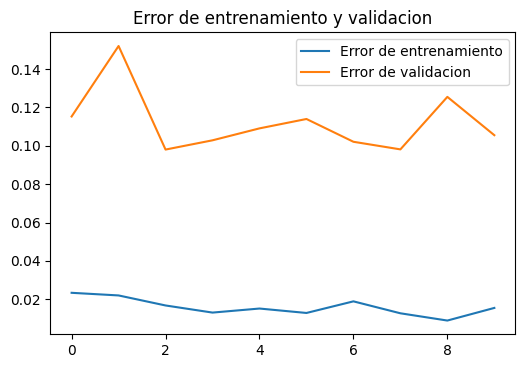

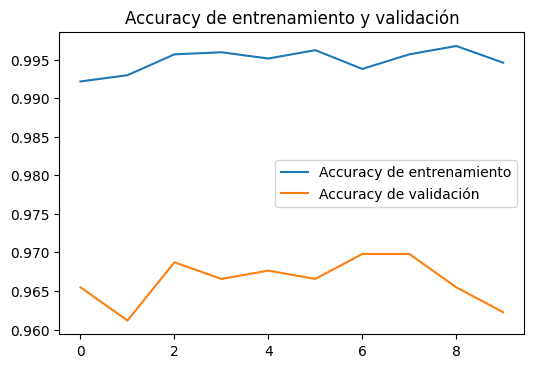

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(dpi=100)
plt.plot(epochs, loss, label='Error de entrenamiento')
plt.plot(epochs, val_loss, label='Error de validacion')
plt.title('Error de entrenamiento y validacion')
plt.legend()
fname = results_folder + model_name + ' Training Error.png'  
plt.savefig(fname,dpi=105)

plt.figure(dpi=100)
plt.plot(epochs, acc, label='Accuracy de entrenamiento')
plt.plot(epochs, val_acc, label='Accuracy de validación')
plt.title('Accuracy de entrenamiento y validación')
plt.legend()
fname = results_folder + model_name + ' Training Accuracy.png'  
plt.savefig(fname,dpi=105)
plt.show()

### Ya con las épocas que son apropiadas:


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=10,
      validation_data=val_generator,
      validation_steps=val_steps)

### La predicción y resultado

In [ ]:
predictions = model.predict(test_generator) #,batch_size=test_batch)
print("Shape:",predictions.shape)

# getting the labels
pred_labels = list(np.argmax(predictions, axis=-1))

# getting true labels
true_labels = test_generator.classes

# get the confusion plot
cm = confusion_matrix(true_labels, pred_labels)

Shape: (1923, 3)


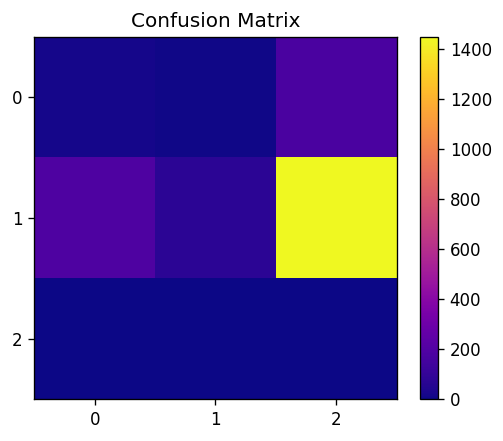

In [ ]:
plt.figure(figsize=(5,4),dpi=120)
plt.imshow(cm, interpolation='nearest',cmap='plasma')
plt.title("Confusion Matrix")
plt.colorbar()
plt.yticks([0,1,2])
plt.xticks([0,1,2])
fname = results_folder + model_name + ' CM.png'
plt.savefig(fname,dpi=120)
plt.show()

## Para 2 clases

#### Hacer el preprocesamiento y selección de índices

In [ ]:
print("Baroque:",available_df[available_df['Period']=='Baroque'].shape[0])
print("Romanticism:",available_df[available_df['Period']=='Romanticism'].shape[0])

Baroque: 2641
Romanticism: 5222


In [ ]:
2641*0.8

2112.8

In [ ]:
prds = ['Baroque','Romanticism']
#------ Separar primero, en prueba y entrenamiento
# counts = [available_df[available_df['Period']==prd].shape[0] for prd in prds] 
size = 2100
train_idxs = []
test_idxs = []
for k in range(2):
    idxs = available_df[available_df['Period']==prds[k]].index.to_list()
    idxs_train = np.random.choice(idxs,size=size,replace=False)
    train_idxs.append(idxs_train)
    D = np.array([x for x in idxs if x not in idxs_train])
    test_idxs.append(D)
test_size = min(test_idxs[0].shape[0],test_idxs[1].shape[0])
for k in range(2):
    test_idxs[k] = np.random.choice(test_idxs[k],size=test_size,replace=False)
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0])
print("Tamaño de tests:",test_idxs[0].shape[0],test_idxs[1].shape[0])
print("--------------")
#------ Separar el entrenamiento en validación y entrenamiento
r = 0.8
n = train_idxs[0].shape[0]
val_idxs = []
for k in range(2):
    train = train_idxs[k]
    tr = np.random.choice(train,size=math.floor(r*n),replace=False)
    train_idxs[k] = tr
    D = np.array([x for x in train if x not in tr])
    val_idxs.append(D)
print("Tamaño de trains:",train_idxs[0].shape[0],train_idxs[1].shape[0])
print("Tamaño de validations:",val_idxs[0].shape[0],val_idxs[1].shape[0])
print("--------------")

Tamaño de trains: 2100 2100
Tamaño de tests: 541 541
--------------
Tamaño de trains: 1680 1680
Tamaño de validations: 420 420
--------------


Guardar los índices para siempre hacer las pruebas sobre las mismas instancias de entrenamiento

In [ ]:
train_df = pd.DataFrame(data={'train_0':train_idxs[0],'train_1':train_idxs[1]})
val_df = pd.DataFrame(data={'val_0':val_idxs[0],'val_1':val_idxs[1]})
test_df = pd.DataFrame(data={'test_0':test_idxs[0],'test_1':test_idxs[1]})
train_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/train-idxs.p')
val_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/val-idxs.p')
test_df.to_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/test-idxs.p')

#### Trabajar con índices ya pre-establecidos

In [133]:
available_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/registro-total-imagenes.p')
available_df

,Img_Path,Period
0,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
1,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
2,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
3,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
4,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
...,...,...
9578,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9579,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9580,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism
9581,/content/drive/My Drive/Diplomado Python/Noteb...,Romanticism


Leer los índices...

In [134]:
train_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/train-idxs.p')
val_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/val-idxs.p')
test_df = pd.read_pickle('/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/test-idxs.p')

train_idxs = [train_df['train_0'].values, train_df['train_1'].values]
val_idxs = [val_df['val_0'].values, val_df['val_1'].values]
test_idxs = [test_df['test_0'].values, test_df['test_1'].values]

In [135]:
total_train = train_idxs[0].shape[0]+train_idxs[1].shape[0]
print("En total hay",total_train,"instancias de entrenamiento")
total_val = val_idxs[0].shape[0]+val_idxs[1].shape[0]
print("En total hay",total_val,"instancias de validación")
total_test = test_idxs[0].shape[0]+test_idxs[1].shape[0]
print("En total hay",total_val,"instancias de prueba")
(train_batch,train_steps) = (min(largest_prime_factor(total_train),
                                    total_train//largest_prime_factor(total_train)),
                             max(largest_prime_factor(total_train),
                                    total_train//largest_prime_factor(total_train))) 
(val_batch,val_steps) = (min(largest_prime_factor(total_val),
                                    total_val//largest_prime_factor(total_val)),
                             max(largest_prime_factor(total_val),
                                    total_val//largest_prime_factor(total_val))) 
(test_batch,test_steps) = (min(largest_prime_factor(total_test),
                                    total_test//largest_prime_factor(total_test)),
                             max(largest_prime_factor(total_test),
                                    total_test//largest_prime_factor(total_test))) 
print("Separar train como:\n","  batches ->",train_batch,"steps ->",train_steps) 
print("Separar validation como:\n","  batches ->",val_batch,"steps ->",val_steps) 
print("Separar test como:\n","  batches ->",test_batch,"steps ->",test_steps) 

En total hay 3360 instancias de entrenamiento
En total hay 840 instancias de validación
En total hay 840 instancias de prueba
Separar train como:
   batches -> 7 steps -> 480
Separar validation como:
   batches -> 7 steps -> 120
Separar test como:
   batches -> 2 steps -> 541


### Pre-procesamiento de las imágenes

In [136]:
available_df = available_df[available_df['Period']!='Classicism'].copy()
available_df.shape

(7913, 2)

In [137]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Train:")
train_idxs = np.concatenate((train_idxs[0],train_idxs[1]))
train_generator = train_datagen.flow_from_dataframe(
                        available_df.loc[train_idxs], 
                        x_col = 'Img_Path', 
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = train_batch,
                        )

print("Validation:")
val_idxs = np.concatenate((val_idxs[0],val_idxs[1]))
val_generator = val_datagen.flow_from_dataframe(
                        available_df.loc[val_idxs], 
                        x_col = 'Img_Path', 
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = val_batch,
                        )

print("Test:")
test_idxs = np.concatenate((test_idxs[0],test_idxs[1]))
test_generator = test_datagen.flow_from_dataframe(
                        available_df.loc[test_idxs], 
                        x_col = 'Img_Path', 
                        y_col = 'Period',
                        class_mode = 'categorical',
                        target_size = (256,256),
                        batch_size = test_batch,
                        )

Train:
Found 3360 validated image filenames belonging to 2 classes.
Validation:
Found 840 validated image filenames belonging to 2 classes.
Test:
Found 1082 validated image filenames belonging to 2 classes.


### El modelo

In [158]:
model_name = "23 [two totally balanced classes + full T images + tiny-NN + BN + GDrop30]"
results_folder = '/content/drive/My Drive/Diplomado Python/Notebooks & Resources/Proyecto Final/Resultados/'

Módelo Grande

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Modelo Pequeño

In [96]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3,padding='same', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianDropout(0.50),
    # tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Modelo Tiny

In [168]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    # tf.keras.layers.Conv2D(32, 3, activation='relu', 
    #                        input_shape=(256, 256, 3)),
    tf.keras.layers.Conv2D(32, 3,padding='same', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3,padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianDropout(0.30),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0015)),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0

### Here goes nothing

In [165]:
number_epochs = 15

In [169]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=0)

history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=number_epochs,
      validation_data=val_generator,
      validation_steps=val_steps,
      callbacks=[early_callback] 
      )

Epoch 1/15
480/480 [==============================] - 93s 194ms/step - loss: 2.0597 - accuracy: 0.8214 - val_loss: 23.0876 - val_accuracy: 0.5000
Epoch 2/15
480/480 [==============================] - 94s 197ms/step - loss: 2.4324 - accuracy: 0.8869 - val_loss: 8.6983 - val_accuracy: 0.6595
Epoch 3/15
480/480 [==============================] - 94s 196ms/step - loss: 1.7351 - accuracy: 0.9256 - val_loss: 0.9094 - val_accuracy: 0.9607
Epoch 4/15
480/480 [==============================] - 93s 194ms/step - loss: 1.4287 - accuracy: 0.9387 - val_loss: 1.0461 - val_accuracy: 0.9643


¿Guardar el módelo con muchas épocas?

In [122]:
model_folder = '/content/drive/My Drive/Models [MIDI Classification]/'
fname = model_folder + 'model' + model_name + '.h5'
model.save(fname)

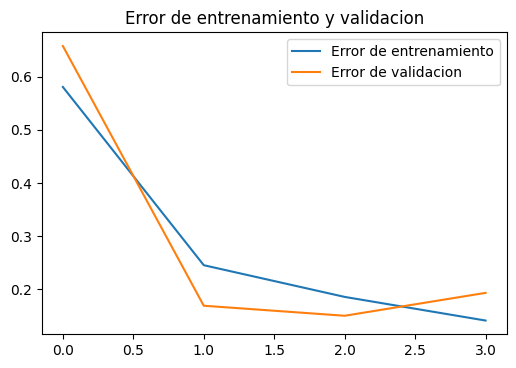

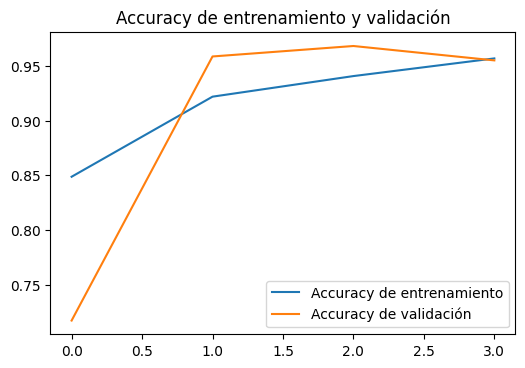

In [150]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(dpi=100)
plt.plot(epochs, loss, label='Error de entrenamiento')
plt.plot(epochs, val_loss, label='Error de validacion')
plt.title('Error de entrenamiento y validacion')
plt.legend()
fname = results_folder + model_name + str(number_epochs) + 'epochs - Training Error.png'  
plt.savefig(fname,dpi=105)

plt.figure(dpi=100)
plt.plot(epochs, acc, label='Accuracy de entrenamiento')
plt.plot(epochs, val_acc, label='Accuracy de validación')
plt.title('Accuracy de entrenamiento y validación')
plt.legend()
fname = results_folder + model_name + str(number_epochs) + 'epochs - Training Accuracy.png'  
plt.savefig(fname,dpi=105)
plt.show()

### Ya con las épocas que son apropiadas:


In [118]:
number_epochs = 3

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', 
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.GaussianDropout(0.50),
    tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [119]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,
      epochs=number_epochs,
      validation_data=val_generator,
      validation_steps=val_steps)

Epoch 1/2
480/480 [==============================] - 92s 191ms/step - loss: 0.3004 - accuracy: 0.8824 - val_loss: 0.1741 - val_accuracy: 0.9595
Epoch 2/2
480/480 [==============================] - 92s 193ms/step - loss: 0.1443 - accuracy: 0.9586 - val_loss: 0.1465 - val_accuracy: 0.9679


### La predicción y resultado

In [170]:
from sklearn.metrics import accuracy_score, recall_score

predictions = model.predict(test_generator) #,batch_size=test_batch)

# getting the labels
pred_labels = list(np.argmax(predictions, axis=-1))

# getting true labels
true_labels = test_generator.classes

# get the confusion plot
cm = confusion_matrix(true_labels, pred_labels)

# print the confussion matrix
print(cm)

# Accuracy & Recall
print("Accuracy score:",accuracy_score(true_labels, pred_labels))
print("Recall score:",recall_score(true_labels, pred_labels))

[[281 260]
 [281 260]]
Accuracy score: 0.5
Recall score: 0.4805914972273567


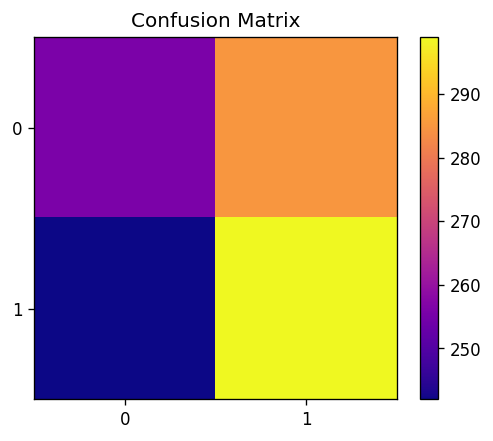

In [152]:
plt.figure(figsize=(5,4),dpi=120)
plt.imshow(cm, interpolation='nearest',cmap='plasma')
plt.title("Confusion Matrix")
plt.colorbar()
plt.yticks([0,1])
plt.xticks([0,1])
fname = results_folder + model_name + str(number_epochs) + 'epochs ' + 'CM.png'
plt.savefig(fname,dpi=120)
plt.show()

¿Guardar el módelo con las épocas correctas?

In [ ]:
model_folder = '/content/drive/My Drive/Models [MIDI Classification]/'
fname = model_folder + 'model' + model_name + str(number_epochs) + '.h5'
model.save(fname)